# Desafio Economapas

## 1. Definição do problema

Esta solução apresentada abaixo faz parte do desafio proposto pela Economapas como parte do processo seletivo para a posição de Engenheiro de dados. A partir de um conjunto de dados fornecidos por eles, foi proposto entender por meio de técnicas de manipulação de dados, quais fatores levam um cliente a ser convertido como lead (vendido). A solução deve responder as seguintes perguntas:

- Quais os fatores/características você considerou na análise?
- Quais os fatores/características de maior influência para que um lead realize a contratação?
- Como foi possível chegar a essa conclusão?
- A partir dessa análise, que recomendação você daria ao setor de marketing, visando aumentar as chances de conversão em futuras campanhas/investimentos?


## 2. Importação das bibliotecas

In [1]:
#Bibliotecas para leitura, visualização dos dados e manipulação
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import numpy as np

# Bibliotecas com modelos de Machine Learning
from xgboost.sklearn import XGBClassifier
from category_encoders import TargetEncoder

#Bibliotecas para validação dos modelos preditivos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Biblioteca para dados desbalanceados
from imblearn.over_sampling import SMOTE

# Biblioteca para ocultar avisos
import warnings
warnings.filterwarnings('ignore')

## 3. Leitura dos dados

In [2]:
#Leitura dos dados
data_1 = pd.read_excel('Desafio Economapas - Engenheiro de Dados 2021 - PLANILHA TESTE.xlsx', engine='openpyxl', sheet_name= 0)
data_2 = pd.read_excel('Desafio Economapas - Engenheiro de Dados 2021 - PLANILHA TESTE.xlsx', engine='openpyxl', sheet_name= 1)
data_3 = pd.read_excel('Desafio Economapas - Engenheiro de Dados 2021 - PLANILHA TESTE.xlsx', engine='openpyxl', sheet_name= 2)
data_4 = pd.read_excel('Desafio Economapas - Engenheiro de Dados 2021 - PLANILHA TESTE.xlsx', engine='openpyxl', sheet_name= 3)
data_5 = pd.read_excel('Desafio Economapas - Engenheiro de Dados 2021 - PLANILHA TESTE.xlsx', engine='openpyxl', sheet_name= 4)
data_6 = pd.read_excel('Desafio Economapas - Engenheiro de Dados 2021 - PLANILHA TESTE.xlsx', engine='openpyxl', sheet_name= 5)

In [3]:
#Colocando os dados das planilhas em unico dataframe
df = pd.merge(data_1,data_2)
df = pd.merge(df, data_3)
df = pd.merge(df, data_4)
df = pd.merge(df, data_5)
df = pd.merge(df, data_6)

In [4]:
df

,LEAD_ID,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO
0,11316042,2021-02-10 16:23:30,NÃO,Orgânico,NaN,Varejo,Belém - PA,1-10,Abertura/Expansão
1,11374979,2021-02-17 11:10:28,NÃO,Orgânico,NaN,Varejo,"São Paulo, SP",11-50,NaN
2,11997870,2021-04-15 11:06:00,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN
3,11930537,2021-04-09 13:10:21,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN
4,11899381,2021-04-07 13:13:49,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2392,11331813,2021-02-11 23:24:10,NÃO,Facebook,facebook - cpc,Varejo,São Paulo - SP,11-50,Planejamento estratégico
2393,10846258,2020-12-30 19:26:54,NÃO,Facebook,facebook - cpc,Varejo,Belo Horizonte - MG,1-10,Abertura/Expansão
2394,11562089,2021-03-07 21:33:44,NÃO,Facebook,facebook - cpc,Varejo,Fortaleza - CE,1-10,Outro
2395,11561275,2021-03-07 15:19:06,NÃO,Facebook,facebook - cpc,Varejo,Rio de Janeiro - RJ,0,Ações de marketing/vendas


## 4. Limpeza dos dados

Como a coluna de IDs não tem nenhum impacto na análise dos dados, ela será excluido do dataframe

In [5]:
df.drop('LEAD_ID',axis = 1, inplace = True)

In [6]:
#Obtendo informações das colunas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 0 to 2396
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATA CADASTRO  2397 non-null   datetime64[ns]
 1   VENDIDO        2397 non-null   object        
 2   ORIGEM         2397 non-null   object        
 3   SUB-ORIGEM     1527 non-null   object        
 4   MERCADO        2302 non-null   object        
 5   LOCAL          2397 non-null   object        
 6   PORTE          2202 non-null   object        
 7   OBJETIVO       2184 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 168.5+ KB


In [7]:
#Analisando se há valores duplicados
df.duplicated().sum()

126

In [8]:
df[df.duplicated()]

,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO
291,2021-01-13 16:17:26,SIM,Google,google - cpc,Servicos,Coronel Fabriciano - MG,51-300,Ações de marketing/vendas
292,2021-01-13 16:17:26,SIM,Google,google - cpc,Servicos,Coronel Fabriciano - MG,51-300,Ações de marketing/vendas
293,2021-01-13 16:17:26,SIM,Google,google - cpc,Servicos,Coronel Fabriciano - MG,51-300,Ações de marketing/vendas
294,2021-01-13 16:17:26,SIM,Google,google - cpc,Servicos,Coronel Fabriciano - MG,51-300,Ações de marketing/vendas
295,2021-01-13 16:17:26,SIM,Google,google - cpc,Servicos,Coronel Fabriciano - MG,51-300,Ações de marketing/vendas
...,...,...,...,...,...,...,...,...
455,2021-01-27 09:14:41,SIM,Orgânico,NaN,Servicos,Vitória - ES,1-10,Abertura/Expansão
456,2021-01-27 09:14:41,SIM,Orgânico,NaN,Servicos,Vitória - ES,1-10,Abertura/Expansão
457,2021-01-27 09:14:41,SIM,Orgânico,NaN,Servicos,Vitória - ES,1-10,Abertura/Expansão
458,2021-01-27 09:14:41,SIM,Orgânico,NaN,Servicos,Vitória - ES,1-10,Abertura/Expansão


Como mostrado acima, há 126 valores duplicados neste conjunto de dados. Para corrigir este problema, serão excluidas as linhas duplicadas.

In [9]:
#Excluindo as linhas duplicadas
df.drop_duplicates(inplace = True)

In [10]:
#Resetando o index do dataframe
df.reset_index(inplace = True, drop = True)

In [11]:
#Criando um coluna com o dia da semana do lead
df['DIA SEMANA'] = df['DATA CADASTRO'].dt.weekday

In [12]:
#Convertendo os dados para dias da semana
dia_semana = {
    0 : 'Segunda',
    1 : 'Terça',
    2 : 'Quarta',
    3 : 'Quinta',
    4 : 'Sexta',
    5 : 'Sábado',
    6 : 'Domingo'
}

In [13]:
df['DIA SEMANA'] = df['DIA SEMANA'].map(dia_semana)

In [14]:
df

,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO,DIA SEMANA
0,2021-02-10 16:23:30,NÃO,Orgânico,NaN,Varejo,Belém - PA,1-10,Abertura/Expansão,Quarta
1,2021-02-17 11:10:28,NÃO,Orgânico,NaN,Varejo,"São Paulo, SP",11-50,NaN,Quarta
2,2021-04-15 11:06:00,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,Quinta
3,2021-04-09 13:10:21,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,Sexta
4,2021-04-07 13:13:49,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,Quarta
...,...,...,...,...,...,...,...,...,...
2266,2021-02-11 23:24:10,NÃO,Facebook,facebook - cpc,Varejo,São Paulo - SP,11-50,Planejamento estratégico,Quinta
2267,2020-12-30 19:26:54,NÃO,Facebook,facebook - cpc,Varejo,Belo Horizonte - MG,1-10,Abertura/Expansão,Quarta
2268,2021-03-07 21:33:44,NÃO,Facebook,facebook - cpc,Varejo,Fortaleza - CE,1-10,Outro,Domingo
2269,2021-03-07 15:19:06,NÃO,Facebook,facebook - cpc,Varejo,Rio de Janeiro - RJ,0,Ações de marketing/vendas,Domingo


In [15]:
#Analisando a quantidade de valores unicos em cada coluna
for col in df.columns:
    print('A Coluna',col,'possui',df[col].nunique(),'valores únicos')

A Coluna DATA CADASTRO possui 2270 valores únicos
A Coluna VENDIDO possui 2 valores únicos
A Coluna ORIGEM possui 13 valores únicos
A Coluna SUB-ORIGEM possui 15 valores únicos
A Coluna MERCADO possui 8 valores únicos
A Coluna LOCAL possui 524 valores únicos
A Coluna PORTE possui 6 valores únicos
A Coluna OBJETIVO possui 6 valores únicos
A Coluna DIA SEMANA possui 7 valores únicos


In [16]:
#Separando os dados de acordo com suas informações
date_columns = ['DATA CADASTRO']
categorical_columns = df.select_dtypes('object').columns

In [17]:
categorical_columns

Index(['VENDIDO', 'ORIGEM', 'SUB-ORIGEM', 'MERCADO', 'LOCAL', 'PORTE',
       'OBJETIVO', 'DIA SEMANA'],
      dtype='object')

In [18]:
#Analisando os valores unicos presente em cada coluna
for col in categorical_columns:
    print(df[col].unique())

['NÃO' 'SIM']
['Orgânico' 'Prospecção Ativa' 'Google' 'Linkedin' 'Facebook' 'Youtube'
 'Bing' 'Instagram' 'rep' 'Leads' 'email' 'Inbound Marketing' 'Indicação']
[nan 'Sales Navigator' 'google - cpc' 'linkedin - social' 'facebook - cpc'
 'youtube - cpc' 'bing - cpc' 'instagram - social' 'rep - ximena-cubillos'
 'leads - email' 'linkedin - cpc' 'rep - juliana-gomes'
 'email - economapas' 'Orgânico' 'youtube - social' 'rep - elzir-souza']
['Varejo' nan 'Marketing/Publicidade/Consultoria' 'Tecnologia' 'Servicos'
 'Franqueadora' 'Industria' 'Empreendedor'
 'Imobiliaria/Incorporadora/Construtora']
['Belém - PA' 'São Paulo, SP' '-' 'Rio de Janeiro - RJ' 'Cariacica - ES'
 'Ribeirão Preto - SP' 'Missal - PR' 'Valinhos - SP' 'São Paulo - SP'
 'Piraquara - PR' 'Sorocaba - SP' 'Belo Horizonte - MG' 'Recife - PE'
 'Pederneiras - SP' 'Duque de Caxias - RJ' 'Piedade - SP'
 'Porto Alegre - RS' 'Maceió - AL' 'Campinas - SP' 'Salvador - BA'
 'Primavera do Leste - MT' 'Maringá - PR' 'Goiânia - GO' 'Manau

In [19]:
#Verificando se há valores faltantes
df.isnull().sum()

DATA CADASTRO      0
VENDIDO            0
ORIGEM             0
SUB-ORIGEM       807
MERCADO           95
LOCAL              0
PORTE            195
OBJETIVO         213
DIA SEMANA         0
dtype: int64

In [20]:
df[df.isnull().any(axis=1)]

,DATA CADASTRO,VENDIDO,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO,DIA SEMANA
0,2021-02-10 16:23:30,NÃO,Orgânico,NaN,Varejo,Belém - PA,1-10,Abertura/Expansão,Quarta
1,2021-02-17 11:10:28,NÃO,Orgânico,NaN,Varejo,"São Paulo, SP",11-50,NaN,Quarta
2,2021-04-15 11:06:00,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,Quinta
3,2021-04-09 13:10:21,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,Sexta
4,2021-04-07 13:13:49,NÃO,Prospecção Ativa,Sales Navigator,Varejo,-,NaN,NaN,Quarta
...,...,...,...,...,...,...,...,...,...
2202,2021-03-18 11:51:34,NÃO,Orgânico,NaN,Varejo,Niterói - RJ,0,Outro,Quinta
2203,2021-03-19 16:24:38,NÃO,Orgânico,NaN,Varejo,Cuiabá - MT,0,Outro,Sexta
2204,2021-03-17 15:21:50,NÃO,Orgânico,NaN,Varejo,Criciúma - SC,1-10,Abertura/Expansão,Quarta
2205,2021-04-03 09:41:33,NÃO,Orgânico,NaN,Varejo,Campo Limpo Paulista - SP,1-10,Abertura/Expansão,Sábado


Como temos uma grande quantidade de dados faltantes e todos eles são dados categóricos, eles serão preenchidos com a informação não informados para não criar um distorção dos dados por meio de outros métodos de tratamento dos dados faltantes.

In [21]:
df = df.fillna('Não informado')

## 5. Análise Exploratória dos Dados

In [22]:
sns.set_style('darkgrid')

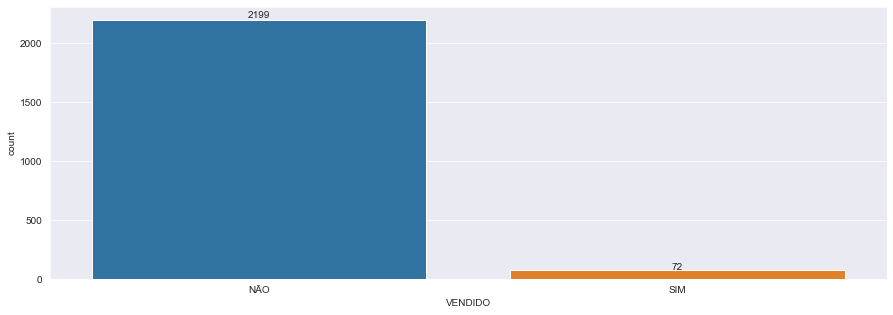

In [23]:
plt.figure(figsize = (15,5))
ax = sns.countplot(df['VENDIDO'])
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2), y = height * 1.01 , s = '{:.0f}'.format(height), ha = 'center')

Como podemos observar cima, há um desbalanceamento entre as classes alvo desta análise, tendo um número muito maior de dados com a informação de que os leads não foram convertidos.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


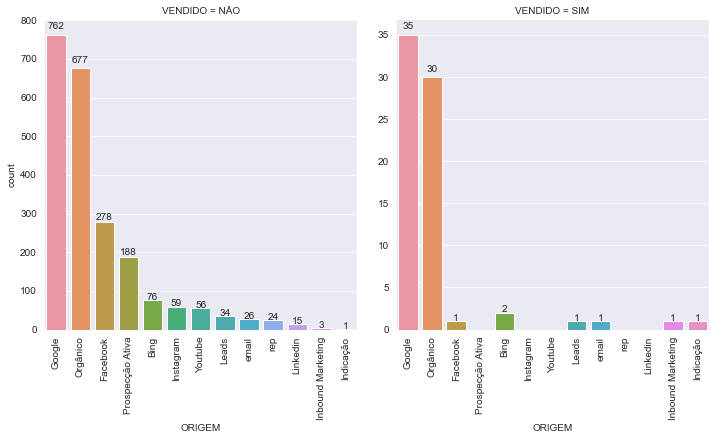

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


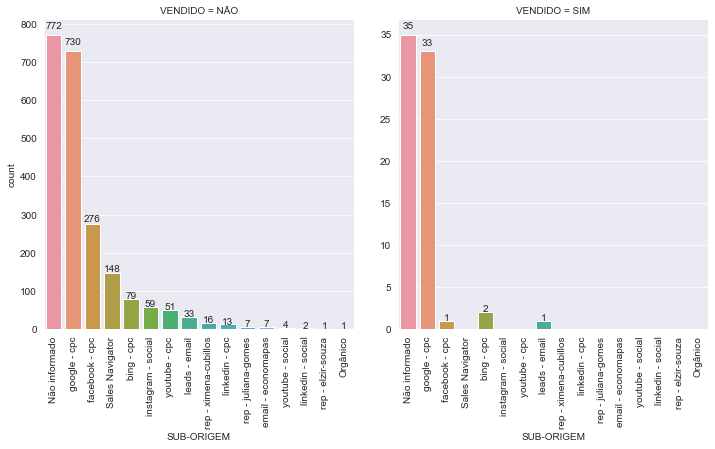

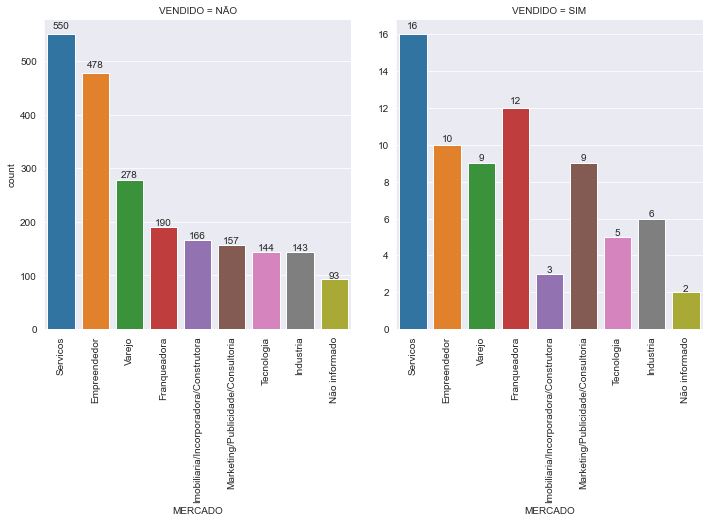

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


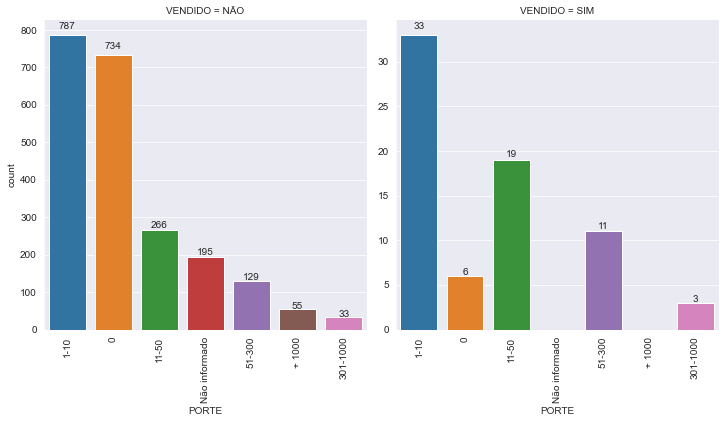

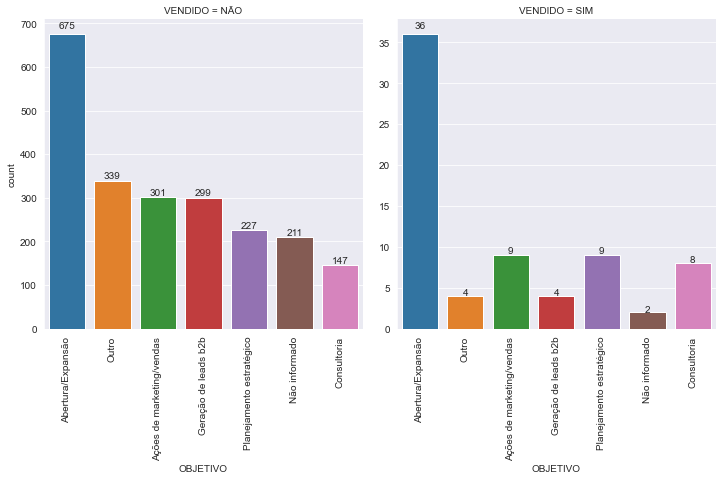

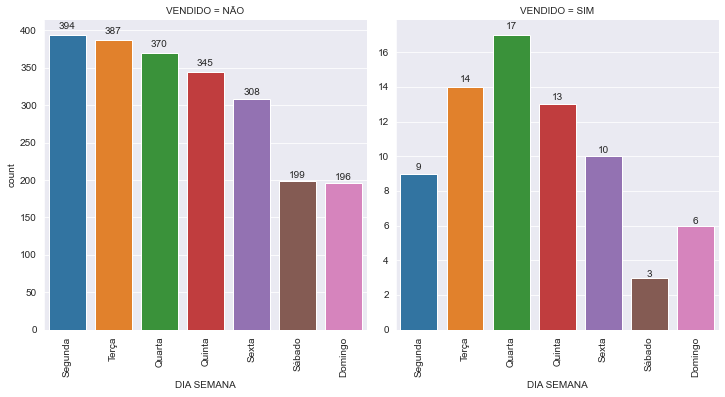

In [24]:
#Observando os a relação entre as variaveis com o lead
for col in categorical_columns[1:]:
    if df[col].nunique() <= 16:
        order = df[df['VENDIDO'] == 'NÃO'][col].value_counts(normalize = True).index
        g = sns.catplot(x = col ,kind='count', col = 'VENDIDO', data=df, sharey=False, order = order)
        g.set_xticklabels(rotation=90)
    
        #for ax in g.axes.flat:
            #ax.yaxis.set_major_formatter(PercentFormatter(1))
        
        for i in range(df['VENDIDO'].nunique()):
            ax = g.facet_axis(0,i)
            for p in ax.patches:
                height = p.get_height()
                ax.text(x = p.get_x()+(p.get_width()/2), y = height * 1.02 , s = '{:.0f}'.format(height), ha = 'center')
    


Plotando os mesmo gráficos mas com a escala em porcentagem.

In [25]:
def plot_percentage(df):
    for col in categorical_columns[1:]:
        if df[col].nunique() <= 16:
            temp_0 = df[df['VENDIDO'] == 'NÃO']
            temp_1 = df[df['VENDIDO'] == 'SIM']
            order = df[df['VENDIDO'] == 'NÃO'][col].value_counts(normalize = True).index
            
            
            fig, ax =plt.subplots(1,2, figsize=(15,5),)
            sns.barplot(x= temp_0[col].value_counts(normalize = True).index, y = temp_0[col].value_counts(normalize = True),
                        order = order, ax = ax[0], )
            ax[0].set_title('VENDIDO = NÃO')
            ax[0].tick_params(labelrotation=90)
            
            
            sns.barplot(x= temp_1[col].value_counts(normalize = True).index, y = temp_1[col].value_counts(normalize = True),
                        order = order, ax=ax[1])
            ax[1].set_title('VENDIDO = SIM')
            ax[1].tick_params(labelrotation=90)
            
            for p in ax[0].patches:
                height = p.get_height()
                ax[0].text(x = p.get_x()+(p.get_width()/2), y = height * 1.02 , s = '{:.1f}'.format(height*100)+'%', ha = 'center')
                
            for p in ax[1].patches:
                height = p.get_height()
                ax[1].text(x = p.get_x()+(p.get_width()/2), y = height * 1.02 , s = '{:.1f}'.format(height*100)+'%', ha = 'center')
            
            fig.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


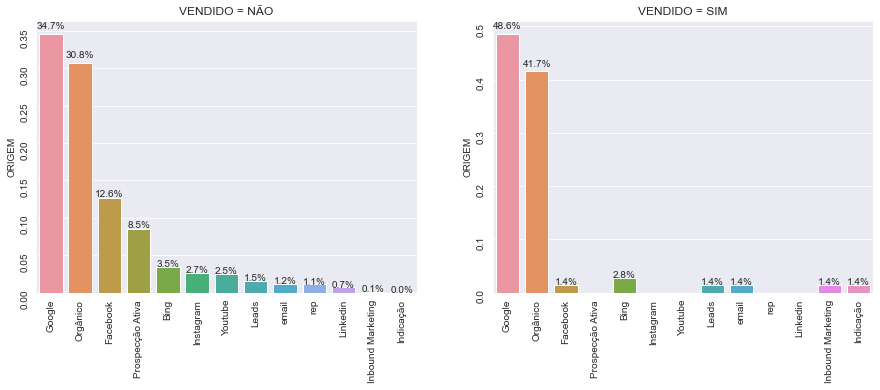

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


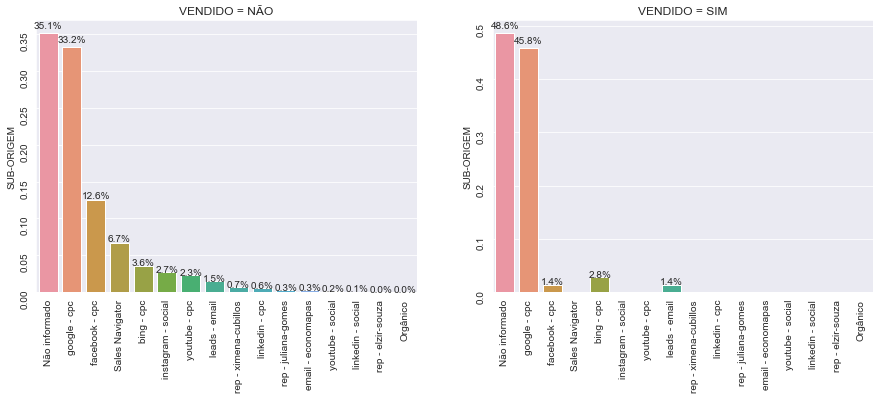

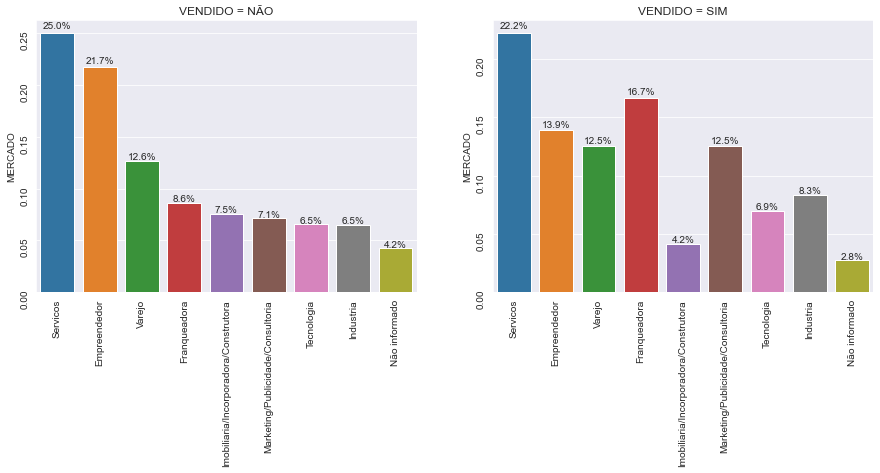

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


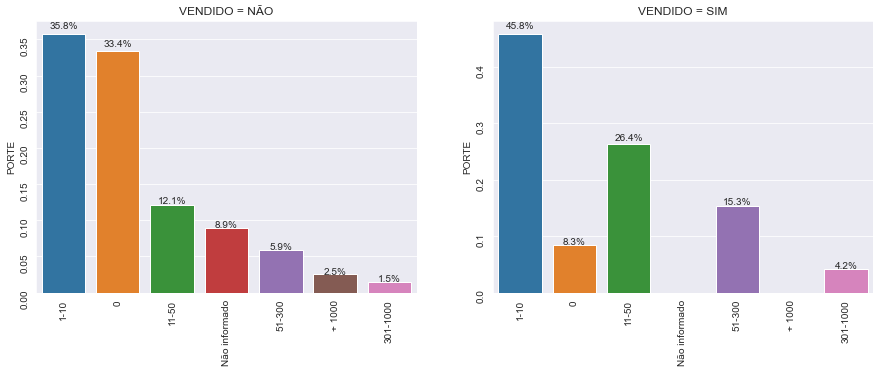

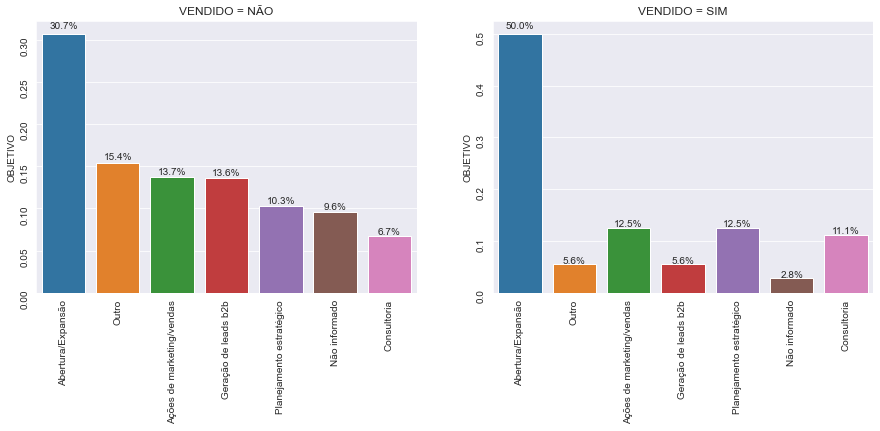

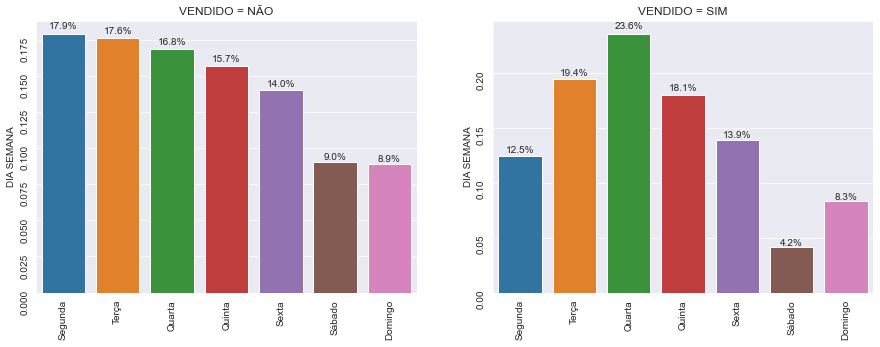

In [26]:
plot_percentage(df)

A partir dos gráficos apresentados acima, ja é possível concluir quais fatores levam um cliente a ser convertido para um lead. Para obter uma segunda análise, será utilizado um algoritmo de machine learning conhecido XGBoost que mostrará quais as variaveis mais importantes para prever se um cliente comprará um produto ou não

## 6. Machine Learning

Para a execução do algoritmo de machine learning, é necessário a realização de tratamentos dos dados especialmente por exister o problema de desbalanceamento entre as classes. Estas etapas serão mostradas abaixo:

In [27]:
vendido = {'NÃO': 0 , 'SIM':1}
df['VENDIDO'] = df['VENDIDO'].map(vendido)

In [28]:
x = df.drop(['VENDIDO','DATA CADASTRO'], axis = 1)
y = df['VENDIDO']

In [29]:
cat_enc = TargetEncoder(cols = categorical_columns[1:]).fit(x,y)

In [30]:
x = cat_enc.transform(x)

In [31]:
x

,ORIGEM,SUB-ORIGEM,MERCADO,LOCAL,PORTE,OBJETIVO,DIA SEMANA
0,0.042433,0.043371,0.031359,4.828527e-10,0.040244,0.050633,0.043928
1,0.042433,0.043371,0.031359,1.052632e-01,0.066667,0.009390,0.043928
2,0.000000,0.000000,0.031359,1.915709e-02,0.000000,0.009390,0.036313
3,0.000000,0.000000,0.031359,1.915709e-02,0.000000,0.009390,0.031447
4,0.000000,0.000000,0.031359,1.915709e-02,0.000000,0.009390,0.043928
...,...,...,...,...,...,...,...
2266,0.003584,0.003610,0.031359,5.970149e-02,0.066667,0.038136,0.036313
2267,0.003584,0.003610,0.031359,3.703704e-02,0.040244,0.050633,0.043928
2268,0.003584,0.003610,0.031359,1.960784e-02,0.040244,0.011662,0.029703
2269,0.003584,0.003610,0.031359,1.550388e-02,0.008108,0.029032,0.029703


In [32]:
x,y = SMOTE(random_state = 66).fit_sample(x,y)

In [33]:
y.value_counts()

1    2199
0    2199
Name: VENDIDO, dtype: int64

In [34]:
model = XGBClassifier()
k = KFold(n_splits=10, random_state= 66, shuffle= True)
acc = np.mean(cross_val_score(model,x,y , cv = k, scoring = 'accuracy'))

[08:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [35]:
acc

0.977946779871609

Como podemos acima, o modelo está com uma accurácia muito satisfatória. Conseguindo ter uma acerto de previsão de um cliente irá se tornar um lead de 97,8%.

In [36]:
model = XGBClassifier()
model.fit(x,y)

[08:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
importance = pd.DataFrame({'Feature': x.columns, 'Importance':model.feature_importances_})
importance = importance.sort_values('Importance', ascending = False)

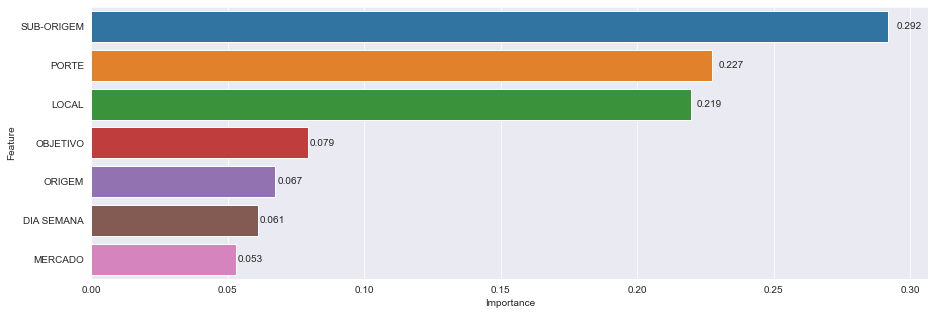

In [38]:
plt.figure(figsize = (15,5))
ax = sns.barplot(data = importance, x = 'Importance',y ='Feature')
for p in ax.patches:
    width = p.get_width()
    ax.text(x = width* 1.01, y = p.get_y() + (p.get_height()/2), s = '{:.3f}'.format(width), va = 'center')

Acima esta sendo mostrado as variavels mais importantes na previsão de um lead de cliente.

#### OBS: As varíaveis acima mostram quais fatores são mais relevantes para a distinguir se a contratação é vendida ou não. Não mostra de forma clara são as caracteristicas exclusivas de um cliente que foi convertido a um lead.

## 6. Respondendo as perguntas do case:

- Quais os fatores/características você considerou na análise?

R: Foram consideradas todas as características informadas nos dados fornecidos e foi adiciona uma coluna com o dia da semana para entender se há alguma relação com o lead.
    
    
- Quais os fatores/características de maior influência para que um lead realize a contratação?

R: Clientes com as seguintes características:
    - Mercado: Franqueadora, Marketing/Pubilicidade/Consultoria
    - Porte: 11-50 e 51-300



- Como foi possível chegar a essa conclusão?

R: Foi possível chegar a esta conclusão a partir da análise dos gráficos mostrados na seção 4 (Análise Exploratória dos Dados), onde está mostrado histogramas individuais se um lead foi convertido a venda ou não. Comparando estes histogramas é possível observar de forma visual quais caracteristicas estão presentes fortemente em uma classe e não esta presente na outra.


- A partir dessa análise, que recomendação você daria ao setor de marketing, visando aumentar as chances de conversão em futuras campanhas/investimentos?

R: A recomendação para o setor de marketing para aumentar a chances de conversão seria investir nos clientes presentes cujo tipo de mercado é voltado para franqueado, marketing, publicidade e consultoria, e empresas cuja porte esta em 11-50 e 51-300, dando uma atenção especial para que eles não deixe de contratar os serviços e também buscas novos clientes com esta caracteristica.

Também foi possível observar algumas caracteristicas que não ajudam na conversão de lead e elas devem ser evitadas:
    - Origem: Prospecção ativa e Facebook.
    - Sub-origem: Facebook cpc e Sales Navigator
    - Porte: 0
    - Objetivo: Outro